1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy.random as npr
from scipy import stats
from scipy import constants


%matplotlib notebook

npr.seed(1234)

<IPython.core.display.Javascript object>


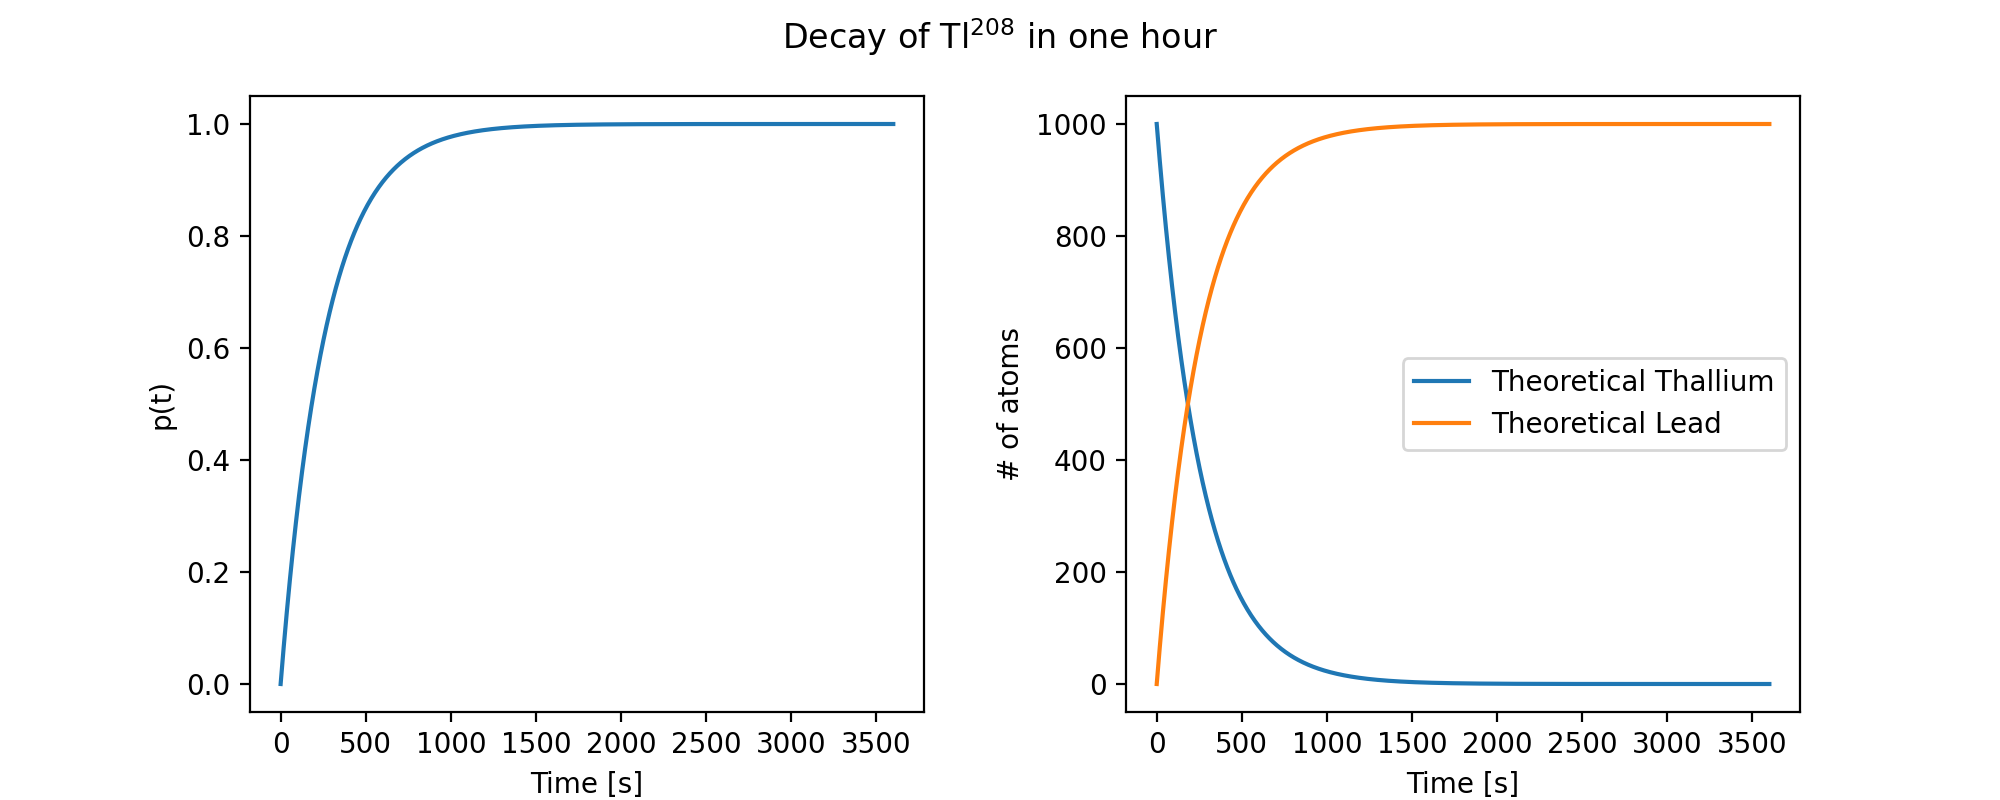

In [2]:
def decay_pdf(t,tau):
    return 1 - np.power(2, -t / tau)

tau = 3.052 * 60 #hl in seconds
T = np.linspace(0, 3600, 1000)
Tl0=1000

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
                    
fig.suptitle(r'Decay of ${\rm Tl}^{208}$ in one hour')
ax[0].plot(T, decay_pdf(T, tau))
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('p(t)')

ax[1].plot(T, Tl0 * (1 - decay_pdf(T, tau)),label='Theoretical Thallium')
ax[1].plot(T, Tl0 * decay_pdf(T,tau),label='Theoretical Lead')
ax[1].legend(loc='best')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('# of atoms')
plt.show()

In [3]:
# Number 1
N=1000
n_steps = 3600
steps = np.arange(n_steps)
tl = np.zeros_like(steps)
pb = np.zeros_like(steps)
tl[0] = N
pb[0] = 0
prob = decay_pdf(steps, tau)
ns=[0]

verbose = False #True for the complete log

rands = npr.uniform(0, 1, size=N)

for step in steps[1:]:
    n_decay = (rands <= prob[step]).sum()
    rands = rands[rands > prob[step]]
    
    ns.append(n_decay)
    tl[step] = tl[step-1] - n_decay
    pb[step] = pb[step-1] + n_decay
    
    if verbose:
        print("Step #", step)
        print(f"\tNumber of Tl atoms: {tl[step-1]}")
        print(f"\tProbability of decaying: {prob[step]:.2e}")
        print(f"\tNumber of atoms that decayed: {n_decay}")
        print(f"\tExpected n_decay: {prob[step] * tl[step - 1]:.2f}")
    
    if tl[step] <= 0.:
        tl[step:] = 0.
        pb[step:] = N
        print("Zero Thallium reached at step #", step)
        break
#ns = np.array(ns)

Zero Thallium reached at step # 2702


<IPython.core.display.Javascript object>


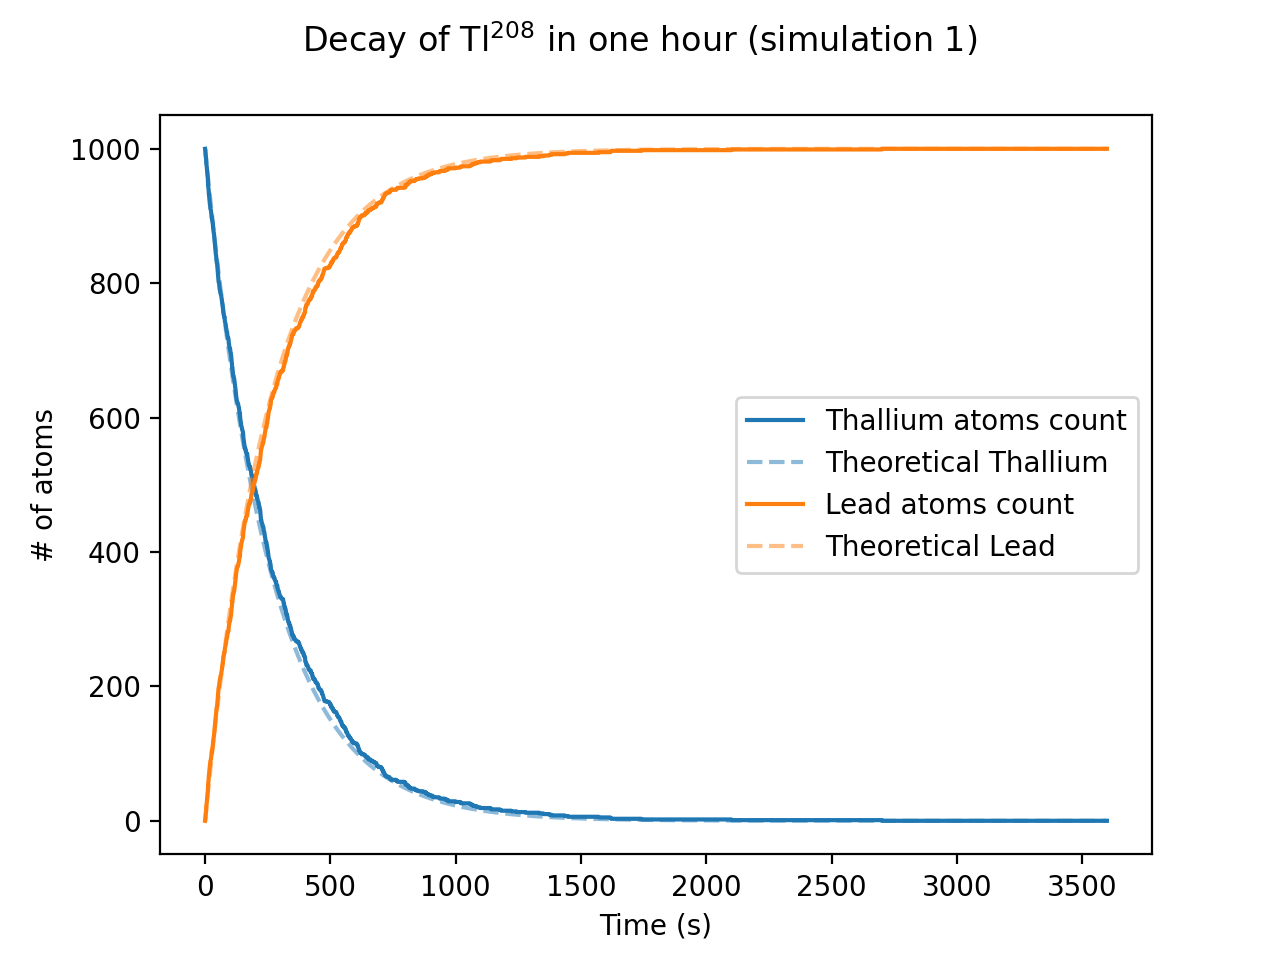

In [4]:
fig,ax = plt.subplots(1,1)
fig.suptitle(r'Decay of ${\rm Tl}^{208}$ in one hour (simulation 1)')
ax.plot(steps, tl, label='Thallium atoms count')
ax.plot(steps, N - N * decay_pdf(steps, tau), 'C0--', alpha=0.5, label='Theoretical Thallium')
ax.plot(steps, pb, label='Lead atoms count')
ax.plot(steps, N * decay_pdf(steps, tau), 'C1--', alpha=0.5, label='Theoretical Lead')
ax.set_xlabel('Time (s)')
ax.set_ylabel('# of atoms')
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


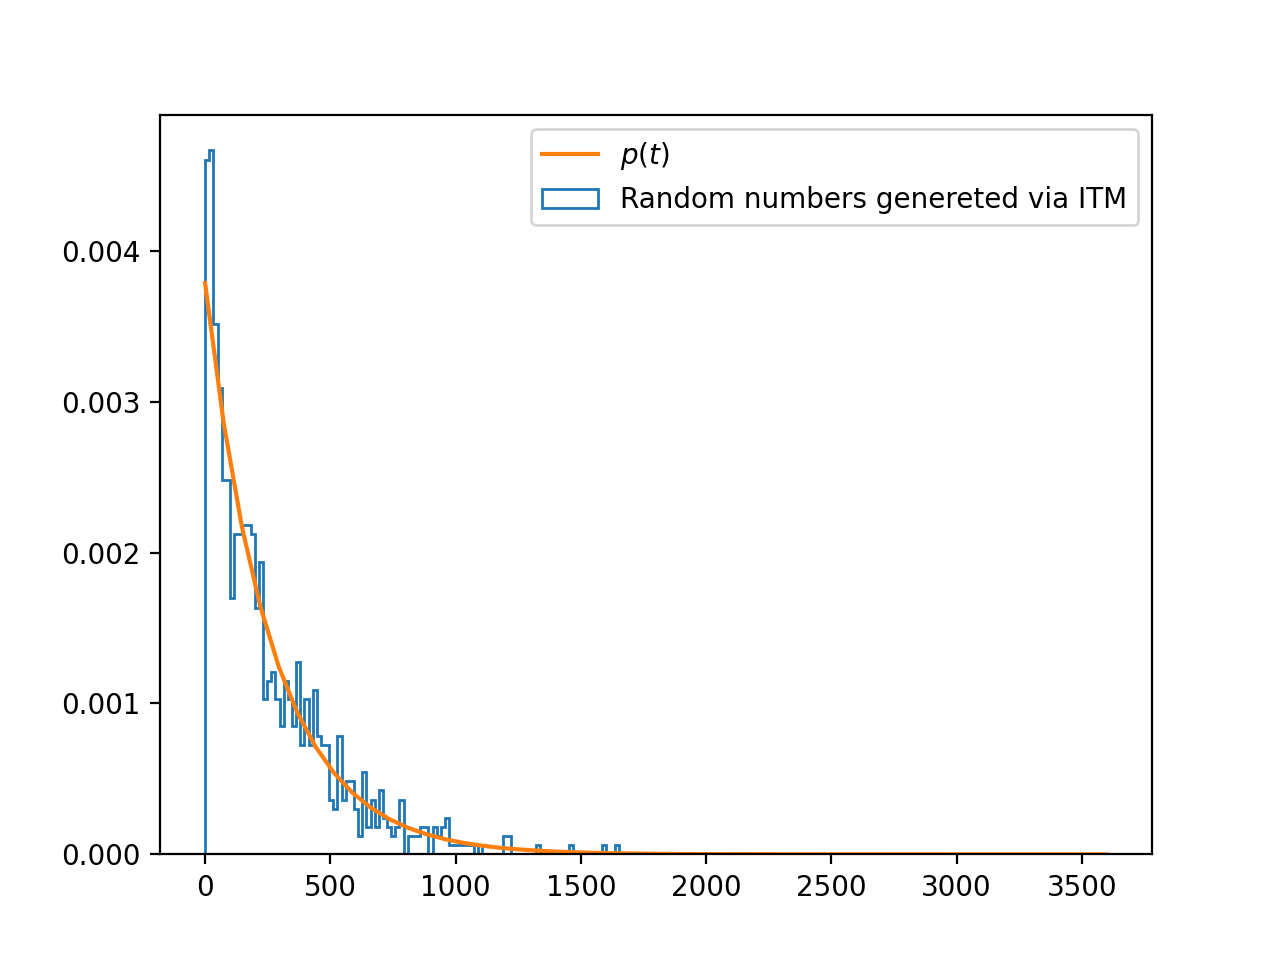

In [5]:
#Number 2
def pdf(t,tau):
    return np.power(2, -t / tau) * np.log(2) / tau

T = np.linspace(0, 3600)


rands = npr.uniform(0, 1, size=N)
rand_t=-tau*np.log2(1-rands)

fig,ax = plt.subplots(1,1)
ax.hist(rand_t, histtype='step', bins=100, density=True, label='Random numbers genereted via ITM')
ax.plot(T,pdf(T,tau),label='$p(t)$')
ax.legend(loc='best')

In [6]:
n_decay=np.zeros(n_steps)

for step in steps:
    n_decay[step]=np.count_nonzero(rand_t<step)
    tl[step]=Tl0-n_decay[step]
    pb[step]=n_decay[step]
    

<IPython.core.display.Javascript object>


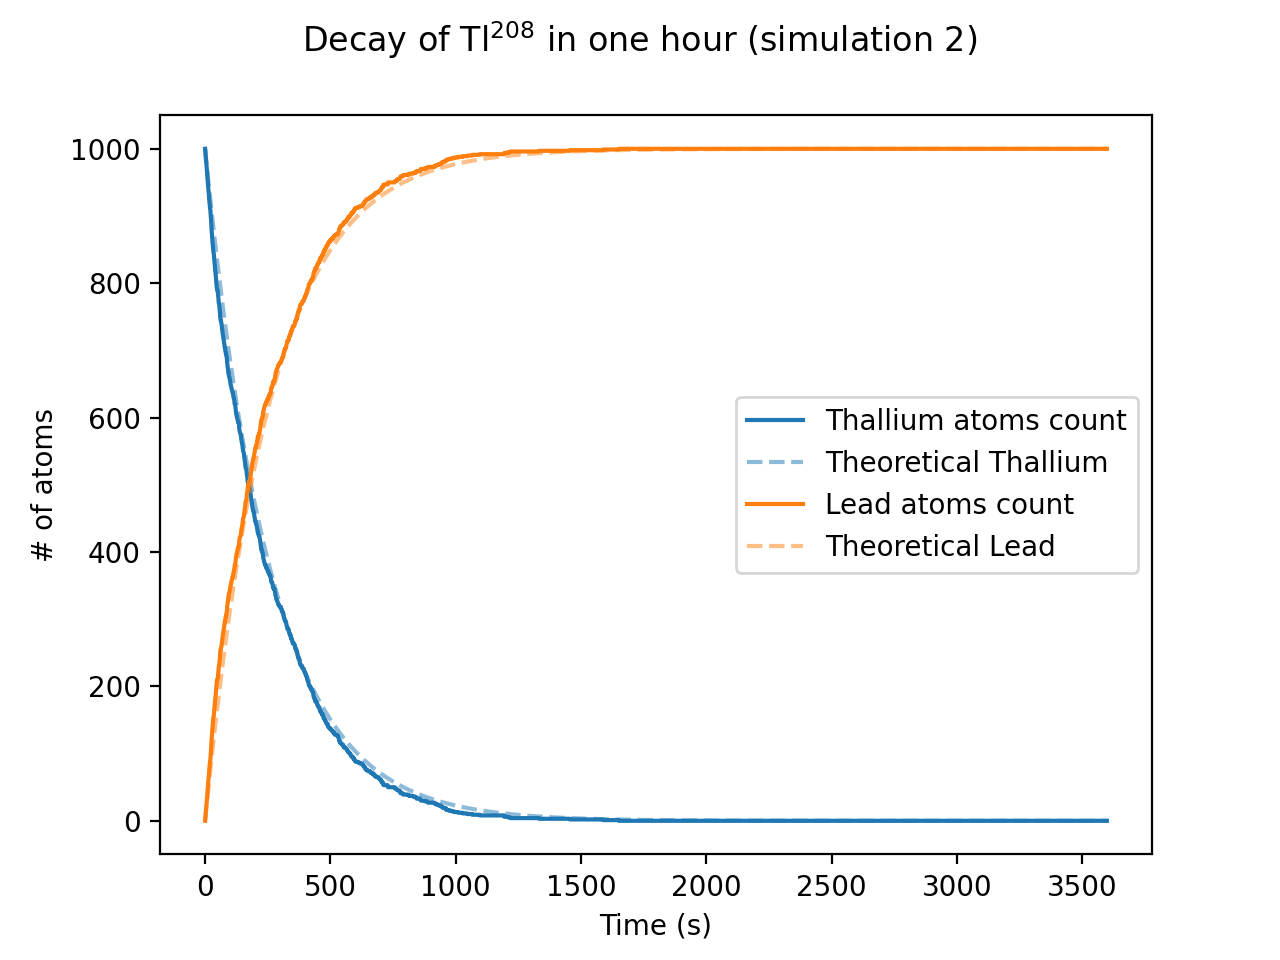

In [7]:
fig,ax = plt.subplots(1,1)
fig.suptitle(r'Decay of ${\rm Tl}^{208}$ in one hour (simulation 2)')
ax.plot(steps, tl, label='Thallium atoms count')
ax.plot(steps, N - N * decay_pdf(steps, tau), 'C0--', alpha=0.5, label='Theoretical Thallium')
ax.plot(steps, pb, label='Lead atoms count')
ax.plot(steps, N * decay_pdf(steps, tau), 'C1--', alpha=0.5, label='Theoretical Lead')
ax.set_xlabel('Time (s)')
ax.set_ylabel('# of atoms')
ax.legend()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

<IPython.core.display.Javascript object>


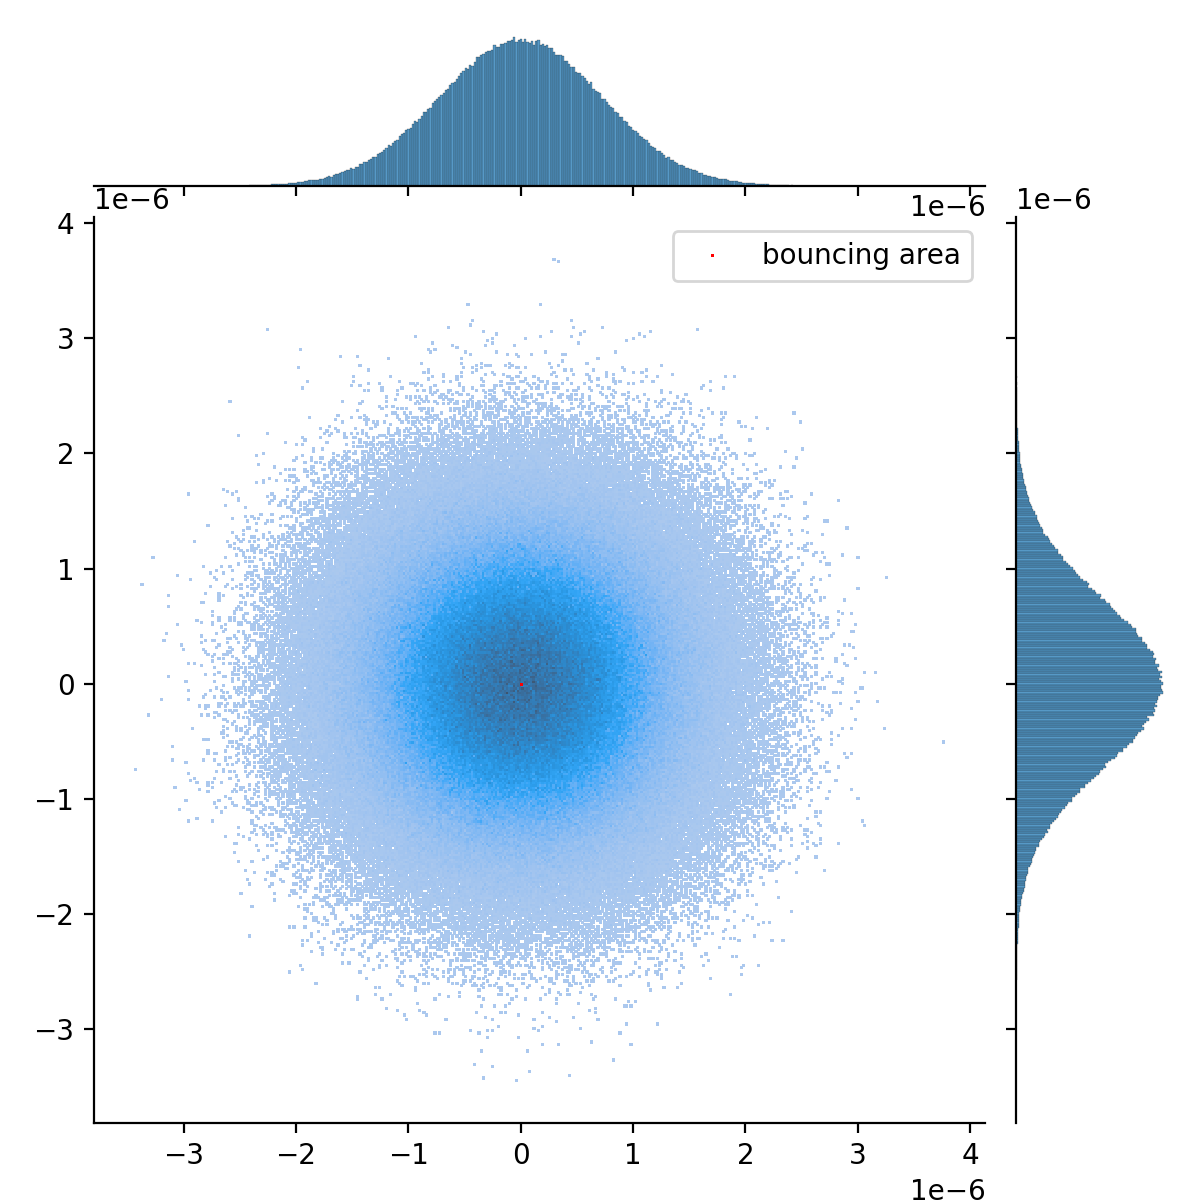

Critical impact parameter: 2.95466114043638e-14 m
Bouncing fraction: 2.7664000000000044 %


In [8]:
def theta(b,Z,e,epsilon,E):
    return 2**np.arctan((Z*e**2)/(2*np.pi*epsilon*E*b))

def circle(x,y):
    return x**2 + y**2 

Z=79
e=1.6021e-19
epsilon=8.8541e-12
E=1.2336e-12 #joule

b_crit=(Z*e**2)/(2*np.pi*epsilon*E)

a0=5.2917e-11 #m
sigma=a0/100
mean=[0,0]
cov=np.diag([sigma,sigma])

N=1e6

vrand = npr.multivariate_normal(mean,cov,size=int(N))
a=sns.jointplot( x=vrand[:,0],y=vrand[:,1], kind="hist")
a.ax_joint.plot([0],[0],'o',ms=b_crit,mec='r',mfc='none',label='bouncing area')
a.ax_joint.legend(loc='best')


bouncing_particles = np.sum(circle(vrand[:,0], vrand[:,1]) >= b_crit)
bouncing_fraction=100-bouncing_particles/N *100

print('Critical impact parameter:',b_crit,'m')
print('Bouncing fraction:',bouncing_fraction,'%')

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

<IPython.core.display.Javascript object>


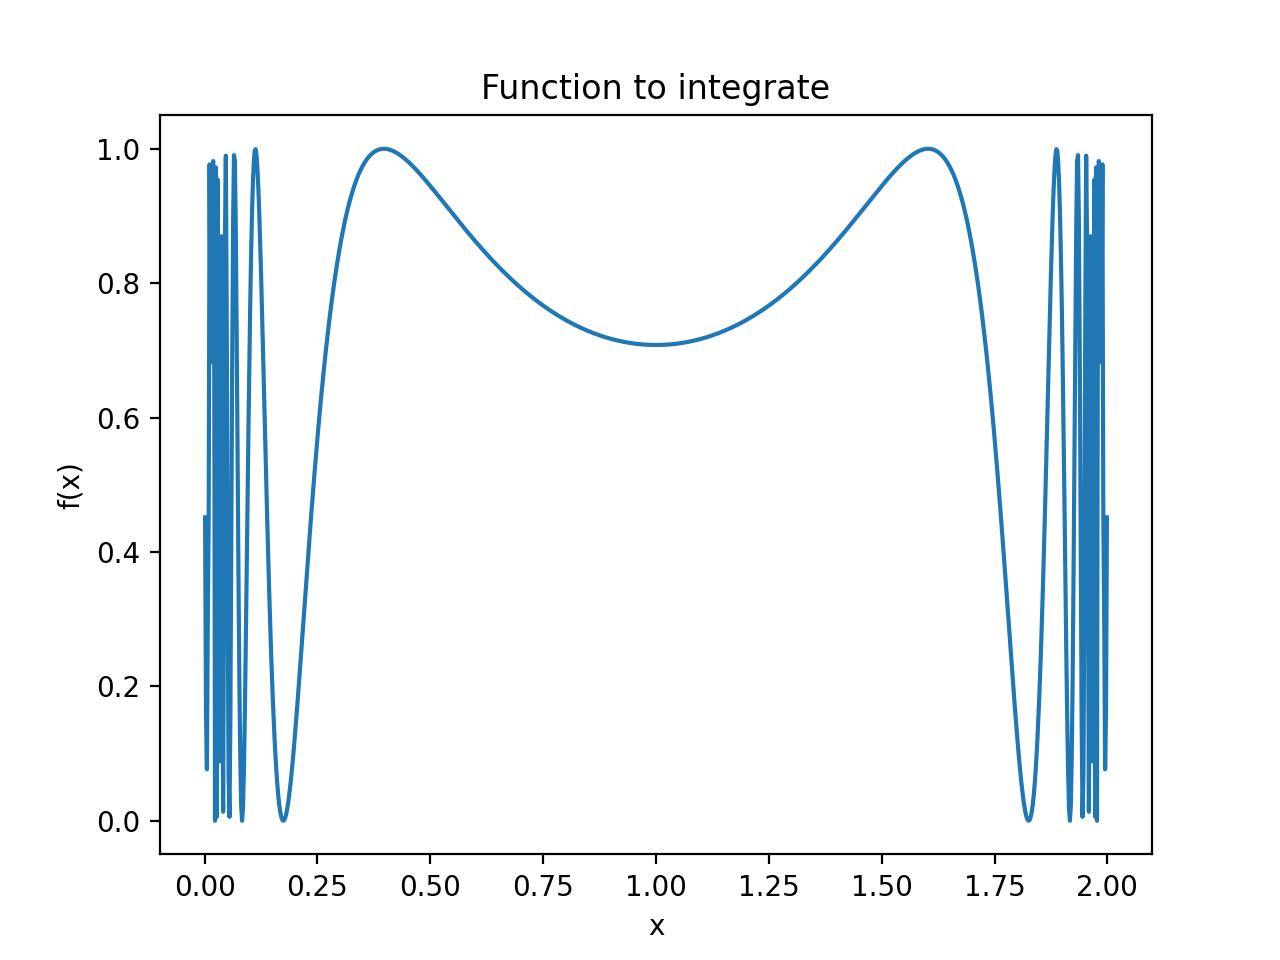

In [9]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

N = 1000
domain = (0, 2)
V = domain[1] - domain[0]

xs=np.linspace(0.001,1.999,1000)

fig=plt.figure()
plt.title('Function to integrate')
plt.plot(xs,f(xs))
plt.xlabel('x')
plt.ylabel('f(x)');

In [10]:
#hit/miss

def hitmiss_integral(f, domain=(0,1), image=(0,1), N=10000):
    x = npr.uniform(domain[0], domain[1], size=N)
    y = npr.uniform(image[0], image[1], size=N)
    count = np.sum(y < f(x))
    return float(domain[1] - domain[0]) * count / N


I = hitmiss_integral(f, domain=domain, N=N)

def mc_var(sigma, N, V):
    return V * np.sqrt(sigma / N)

sigma = np.var(f(xs))
var = mc_var(sigma, N, V)

print('Hit/miss method \n\tValue of the integral in (0,2):',I,'+/-',var)

Hit/miss method 
	Value of the integral in (0,2): 1.472 +/- 0.016619007532990015


In [11]:
#mean value method 1

def mean_integral(f, domain=(0,1), N=10000):
    xrand = npr.uniform(domain[0], domain[1], size=N)
    integral = f(xrand).sum()
    return float(domain[1] - domain[0]) / N * integral


I1 = mean_integral(f, domain, N)
var1 = mc_var(sigma, N, V)

print('Mean value method (1): \n Value of the integral in (0,2):', I, '+/-', var1)

Mean value method (1): 
 Value of the integral in (0,2): 1.472 +/- 0.016619007532990015


<IPython.core.display.Javascript object>


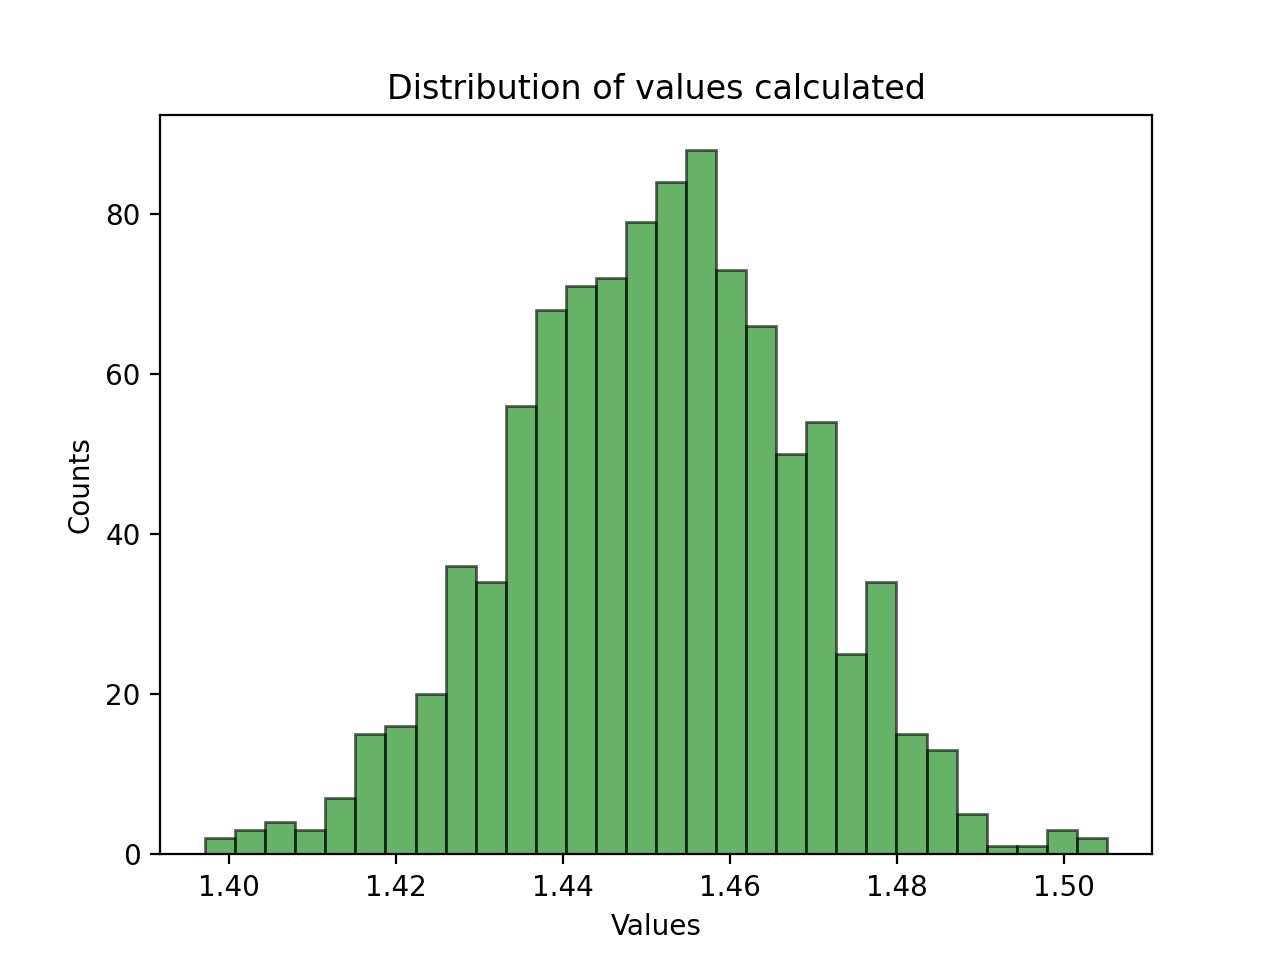

Mean value method (2): 
 Value of the integral in (0,2): 1.4512571459184955 +/- 0.0002919279013964088


In [12]:
#mean value method 2

rep=1000
areas=[]

for i in range(rep):
    I = mean_integral(f, domain, N)
    areas.append(I)

fig=plt.figure()
plt.title('Distribution of values calculated')    
plt.hist(areas,bins=30,ec='black',color='green',alpha=0.6)
plt.ylabel('Counts')
plt.xlabel('Values')

I2=np.mean(areas)
var2=np.var(areas)

print('Mean value method (2): \n Value of the integral in (0,2):',I2,'+/-',var2)

In [13]:
df = pd.DataFrame(
    { 'Method' : ['Hit/Miss','Mean Value (1)','Mean Value (2)'],
      'Value' : [I,I1,I2],
      'Error' : [var,var1,var2]
    }
    )
df

,Method,Value,Error
0,Hit/Miss,1.459575,0.016619
1,Mean Value (1),1.457995,0.016619
2,Mean Value (2),1.451257,0.000292


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [14]:
def circle(x,y):
    return x**2 + y**2 

a=-1
b=1
N=100000
integral=0.0

xrand = npr.uniform(a, b, size=N)
yrand = npr.uniform(a, b, size=N)

integral = np.sum(circle(xrand, yrand) <= 1)
       
I = (b - a)**2 / float(N) * integral    
    
print('Area of ther circle of unit radius:',I)

vrand = npr.uniform(a, b, size=(N, 2))
integral2 = np.sum(np.einsum('...i,...i', vrand, vrand) <= 1)

I2 = (b - a) ** 2 / float(N) * integral

print('Area of ther circle of unit radius (generalizable):', I2)

Area of ther circle of unit radius: 3.13864
Area of ther circle of unit radius (generalizable): 3.13864


In [15]:
#generalization in 10D
from numpy import linalg as LA

n=10 #number of dimension
vrand = npr.uniform(a, b, (N, n))
integral = np.sum(np.einsum('...i,...i', vrand, vrand) <= 1)
        
I_10 = (b - a)**n / float(N) * integral

print('Area of ther circle of unit radius (10D):', I_10)

Area of ther circle of unit radius (10D): 2.8467200000000004


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

<IPython.core.display.Javascript object>


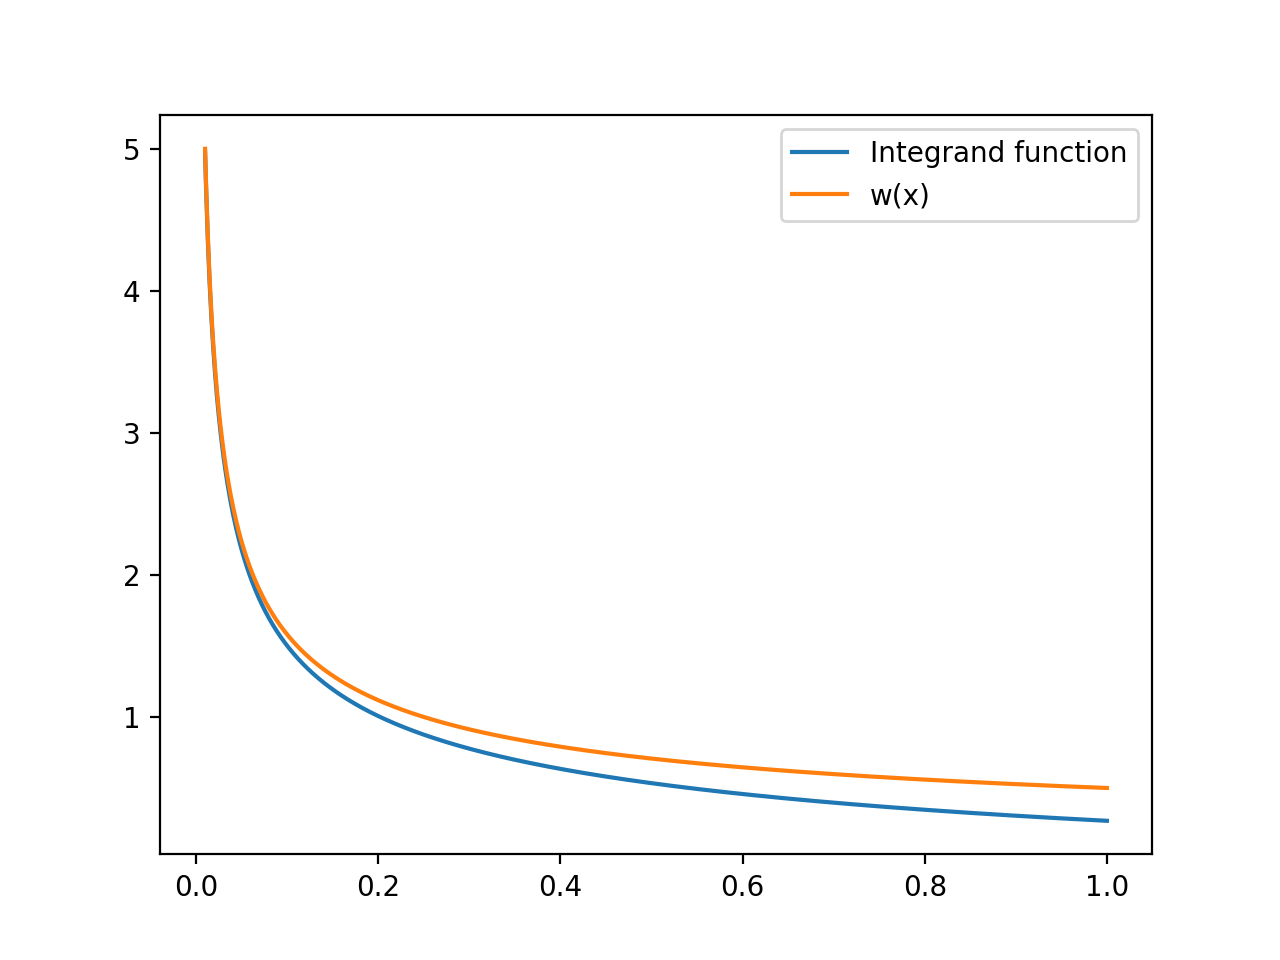

Value of the integral in (0,1): 0.8401688282454525


In [16]:
def g(x):
    return np.power(x, -0.5) / (np.exp(x) + 1)

def w(x):
    return 0.5 * np.power(x, -0.5)

N=100000
xs=np.linspace(0.01, 1, 1000)

fig=plt.figure()
plt.plot(xs,g(xs),label='Integrand function')
plt.plot(xs,w(xs),label='w(x)')
plt.legend();

xrand = npr.beta(0.5, 1., size=N)
w_xrand = g(xrand) / w(xrand)
I = w_xrand.mean()

print('Value of the integral in (0,1):',I)
